## Judge Emotion About Brands & Products

Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.

Citation: http://www.crowdflower.com/data-for-everyone, Added: August 30, 2013 by Kent Cavender-Bares | Data Rows: 9,093

In [638]:
from __future__ import division
import pandas as pd
import numpy as np
import math
from nltk import NaiveBayesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.util import ngrams
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import svm, cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from pandas_confusion import ConfusionMatrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
% matplotlib inline


In [2]:
data = pd.read_csv('data/product_company.csv')

In [3]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 284.2+ KB


In [148]:
# Dropping NaN's
new_data = data[pd.notnull(data['emotion_in_tweet_is_directed_at'])]

## Looking at how the new data is structured

In [149]:
new_data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,3291,3291,3291
unique,3282,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,Positive emotion
freq,3,946,2672


In [150]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 9088
Data columns (total 3 columns):
tweet_text                                            3291 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    3291 non-null object
dtypes: object(3)
memory usage: 102.8+ KB


In [151]:
new_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Renaming the data columns to make it easier to use

In [152]:
# Renaming columns to make it easier to read
new_data.columns = ['tweet_text', 'brand_product', 'sentiment']

## Plotting value counts of the brand/product the tweet is directed at

In [540]:
val_counts_brand = new_data.brand_product.value_counts()
print val_counts_brand

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: brand_product, dtype: int64


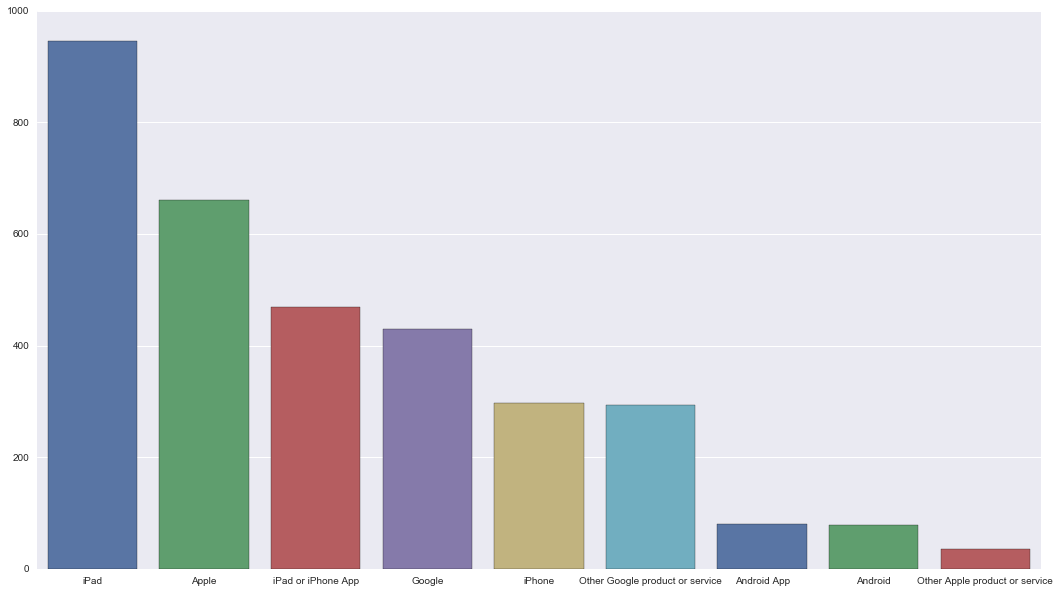

In [541]:
plt.figure(figsize=[18,10])
sns.barplot(x=val_counts_brand.index, y=val_counts_brand.values, palette="deep");

## Re-mapping the sentiment column of new data frame

In [155]:
new_data['sentiment'] = new_data['sentiment'].map({'Positive emotion': 'Positive'
                                                   ,'Negative emotion': 'Negative'
                                                   ,'No emotion toward brand or product': 'Neutral'
                                                   ,"I can't tell": 'Neutral'});

/Users/Sujay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Plotting the value counts of the sentiment column

In [542]:
# Print the val_counts for sentiment
val_counts_sentiment = new_data.sentiment.value_counts()
print val_counts_sentiment

Positive    2672
Negative     519
Neutral      100
Name: sentiment, dtype: int64


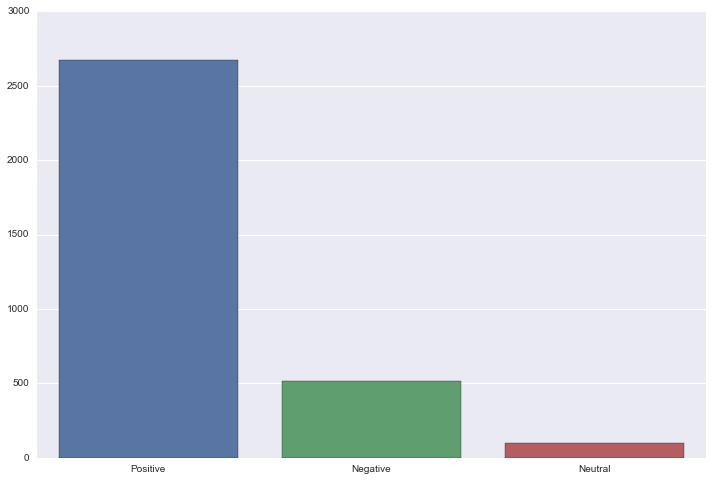

In [543]:
plt.figure(figsize=[12,8])
sns.barplot(x=val_counts_sentiment.index, y=val_counts_sentiment.values, palette="deep");

## Finding sentiments for different product/brands

In [572]:
# Use groupby and count to get counts of sentiments for every brand or product
sentiment_brand_product = new_data.groupby(['brand_product','sentiment']).count()

In [573]:
# Use unstack to reshape the dataframe and make each sentiment type into a column
counts_df = sentiment_brand_product.unstack(level=1)
# Rename the columns
counts_df.columns = [u'Negative', u'Neutral', u'Positive']

In [575]:
# Remove the index name
counts_df.index.name = None

In [582]:
# Make the index a column in the data frame
counts_df.reset_index(level=0, inplace=True)

In [584]:
# Rename the column names
counts_df.columns = [u'Brand_Product',u'Negative', u'Neutral', u'Positive']

In [585]:
counts_df

,Brand_Product,Negative,Neutral,Positive
0,Android,8,1,69
1,Android App,8,1,72
2,Apple,95,23,543
3,Google,68,16,346
4,Other Apple product or service,2,1,32
5,Other Google product or service,47,10,236
6,iPad,125,28,793
7,iPad or iPhone App,63,10,397
8,iPhone,103,10,184


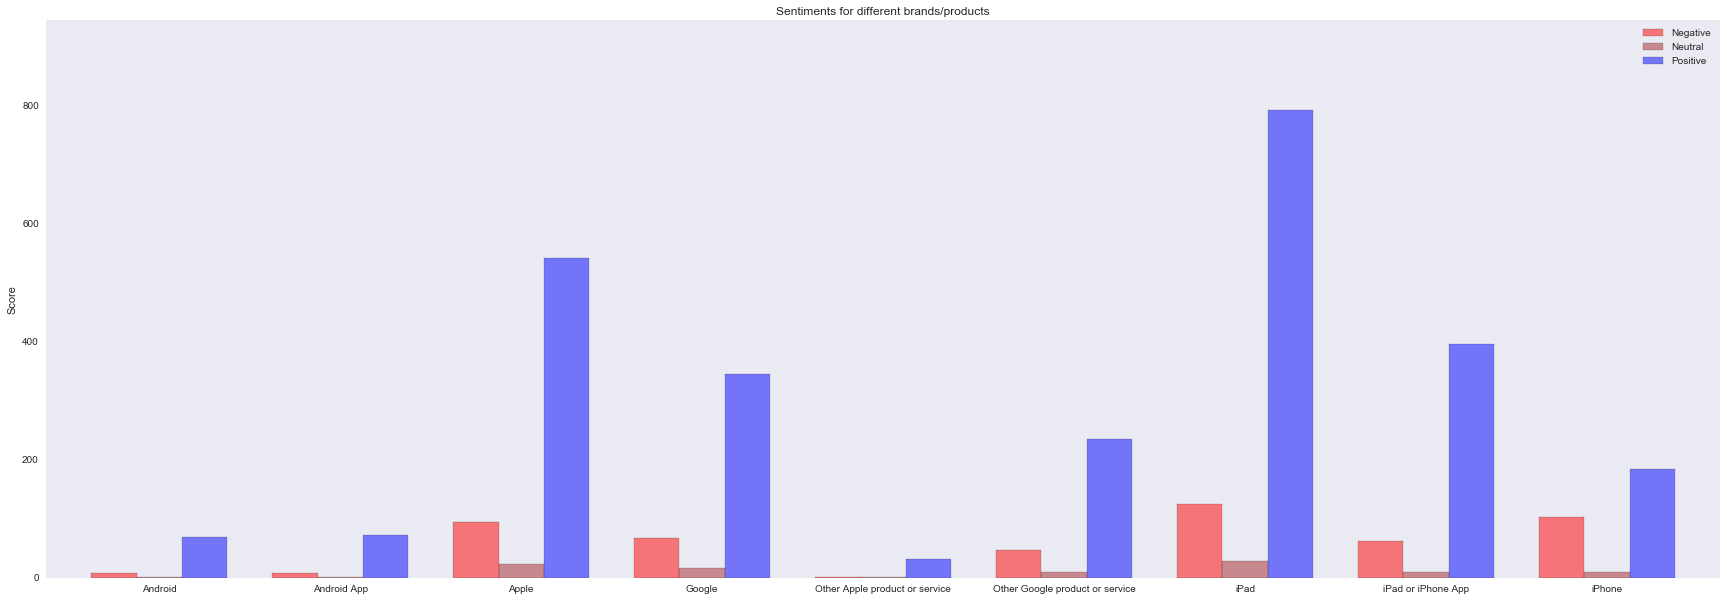

In [596]:
# Setting the positions and width for the bars
pos = list(range(len(counts_df['Negative'])))
width = 0.25

# Plotting the bars
fig, ax = plt.subplots(figsize=(30,10))

# Create a bar with pre_score data,
plt.bar(pos, counts_df['Negative'], width, alpha=0.5, color='Red',label=counts_df['Brand_Product'][0])
plt.bar([p + width for p in pos], counts_df['Neutral'], width, alpha=0.5, color='Brown',label=counts_df['Brand_Product'][1])
plt.bar([p + width*2 for p in pos], counts_df['Positive'], width, alpha=0.5, color='Blue', label=counts_df['Brand_Product'][2])

# Set the y axis label
ax.set_ylabel('Score')

# Set the chart's title
ax.set_title('Sentiments for different brands/products')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(counts_df['Brand_Product'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(counts_df['Negative'] + counts_df['Neutral'] + counts_df['Positive'])] )

# Adding the legend and showing the plot
plt.legend(['Negative', 'Neutral', 'Positive'], loc='upper right')
plt.grid()
plt.show()

## Tokenizing data and also using Regex to filter it

In [158]:
#Citation: https://m.reddit.com/r/learnpython/comments/37sgrv/unclear_on_the_format_of_this_list/

import re
 
regex_str = [
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token.lower() for token in tokens]
    return tokens

In [159]:
# Create a list of lists containing preprocessed data
preprocessed_tweet_text = []
for i in new_data.tweet_text.values:
    preprocessed_tweet_text.append(preprocess(i, lowercase=True))

## Removing stop words and punctuation

In [841]:
# Getting rid of stop words and punctuation
tweet_text_filtered = []
for tweet in preprocessed_tweet_text:
    # We'll get rid of Ts as well as it appears many times
    tweet_text_filtered.append(list(set(tweet) - set(stopwords.words('english') + ['ts'] + ['link'] + ['rt']) - set(string.punctuation)))

In [842]:
tweet_text_filtered[3111]

['#sxsw',
 'walking',
 '#sxswtoolkit',
 'apple',
 'charger',
 'laptop',
 'shades',
 'toolkit',
 'h2o',
 'bike',
 'rei',
 'touch',
 'amp',
 "i'm",
 'ad',
 "what's",
 'iphone']

## Preparing data for some EDA

In [843]:
# Initialize empty lists
hashtags = []
user_handles = []
# Loop over tweets
for tweet in tweet_text_filtered:
    # Loop over every word in the tweet
    for word in tweet:
        # Check whether the word starts with # or @
        if word.startswith('#'):
            hashtags.append(word)
        elif word.startswith('@'):
            user_handles.append(word)

In [844]:
# store the counts for hashtags and user handles
count_hashtags = Counter(hashtags)
count_user_handles = Counter(user_handles)

In [845]:
# Find the top 10 HashTags and UserHandles
top10_hashtags = count_hashtags.most_common(10)
top10_user_handles = count_user_handles.most_common(10)

In [846]:
# Extract the labels and label counts to use for plotting
labels = []
label_counts = []
for (k, v) in top10_hashtags:
    labels.append(k)
    label_counts.append(v)

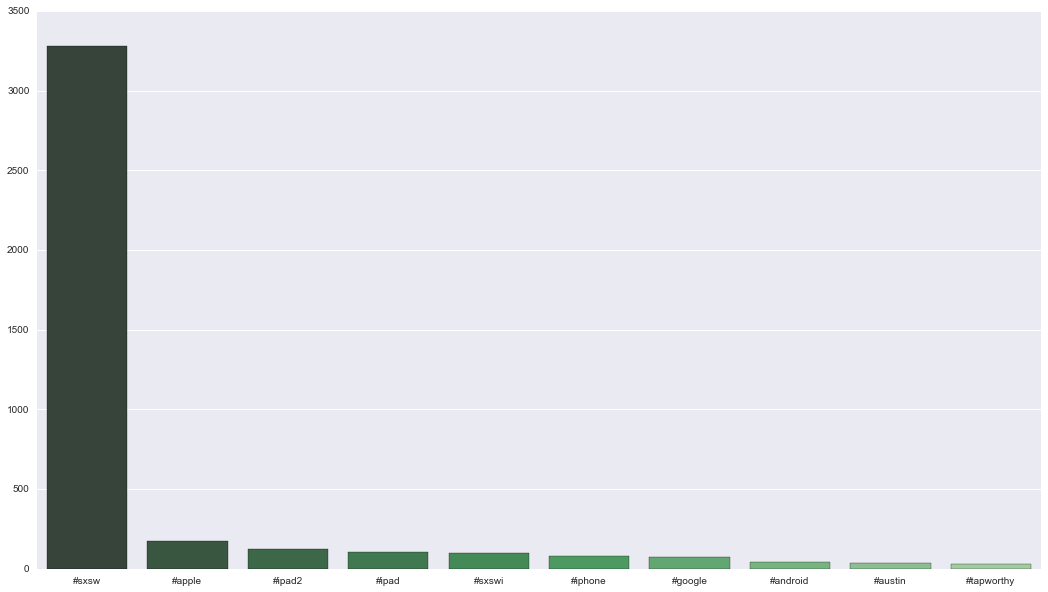

In [847]:
plt.figure(figsize=[18,10])
sns.barplot(x=labels, y=label_counts, palette="Greens_d");

In [848]:
# Extract the labels and label counts to use for plotting
labels = []
label_counts = []
for (k, v) in top10_user_handles:
    labels.append(k)
    label_counts.append(v)

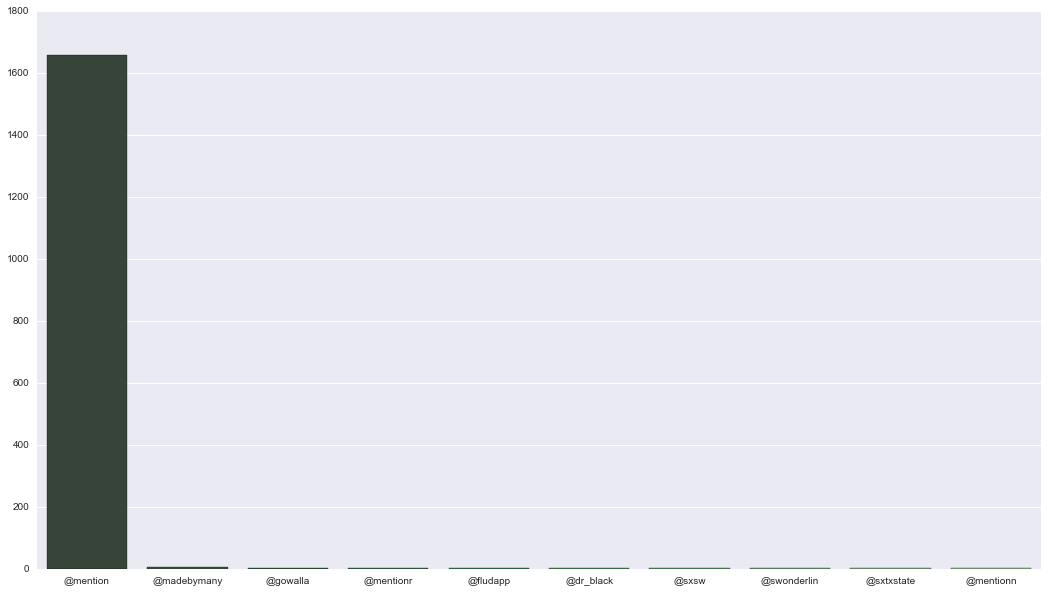

In [849]:
plt.figure(figsize=[18,10])
sns.barplot(x=labels, y=label_counts, palette="Greens_d");

In [850]:
tweet_text_filtered[1]

['ipad',
 '#sxsw',
 '@fludapp',
 "they're",
 'giving',
 'awesome',
 'appreciate',
 'likely',
 'free',
 'also',
 "you'll",
 'design',
 'iphone',
 'app',
 '@jessedee',
 'know']

## Stemming the tokens

In [507]:
tweet_stemmed = []
def conditional_stemmer(word):
    '''
    Input: word
    Output: Stemmed-word based on certain conditions
    '''
    # Check if the word is a handle or hashtag
    if word[0] in ['@', '#']:
        # if yes then don't modify it
        return word
    elif word in ['google','apple','iphone']:
        return word
    # Else stem the word
    return stemmer.stem(word)

In [508]:
# Call the above function and apply it on every tweet
tweet_stemmed = [map(conditional_stemmer, tweet) for tweet in tweet_text_filtered]

In [509]:
tweet_stemmed[1]

[u'ipad',
 '#sxsw',
 '@fludapp',
 u"they'r",
 u'give',
 u'awesom',
 u'appreci',
 u'like',
 u'free',
 u'also',
 u"you'll",
 u'design',
 'iphone',
 u'app',
 '@jessedee',
 u'know']

## Finding the bigrams

In [188]:
# Get the bigrams for every tweet in filtered text
tweet_bigram = []
for tweet in tweet_stemmed:
    tweet_bigram.append(list(ngrams(tweet,2)))

In [506]:
tweet_bigram[1]

[(u'ipad', '#sxsw'),
 ('#sxsw', '@fludapp'),
 ('@fludapp', u"they'r"),
 (u"they'r", u'give'),
 (u'give', u'awesom'),
 (u'awesom', u'appreci'),
 (u'appreci', u'like'),
 (u'like', u'free'),
 (u'free', u'also'),
 (u'also', u"you'll"),
 (u"you'll", u'design'),
 (u'design', 'iphone'),
 ('iphone', u'app'),
 (u'app', '@jessedee'),
 ('@jessedee', u'know')]

In [199]:
# Get all the bigrams in one list
all_bigrams = []
for tweet in tweet_bigram:
    for pair in tweet:
        all_bigrams.append(pair)

In [203]:
all_bigrams[20:30]

[(u'free', u'also'),
 (u'also', u"you'll"),
 (u"you'll", u'design'),
 (u'design', 'iphone'),
 ('iphone', u'app'),
 (u'app', '@jessedee'),
 ('@jessedee', u'know'),
 ('@swonderlin', '#sxsw'),
 ('#sxsw', u'sale'),
 (u'sale', u'also')]

In [204]:
count_tweet_bigrams = Counter(all_bigrams)

In [205]:
# Getting the top 10 bigrams
top10_bigrams = count_tweet_bigrams.most_common(10)

In [207]:
# Extract the labels and label counts to use for plotting
labels = []
label_counts = []
for (k, v) in top10_bigrams:
    labels.append(str(k))
    label_counts.append(v)

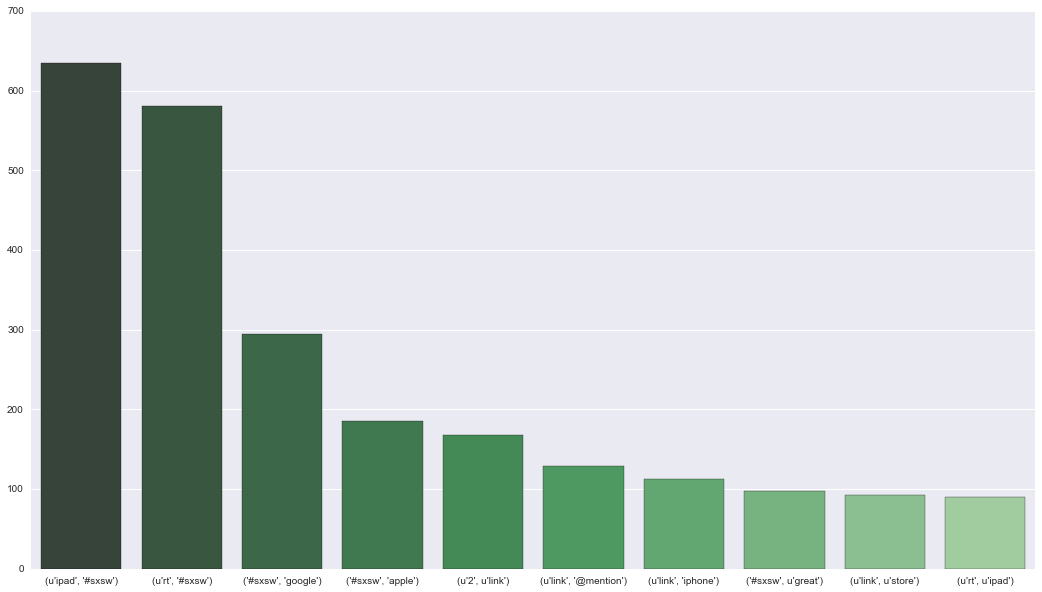

In [208]:
plt.figure(figsize=[18,10])
sns.barplot(x=labels, y=label_counts, palette="Greens_d");

## Filtering data further

In [215]:
# Creating sentences based on tweets
new_sentences = []
for tweet in tweet_stemmed:
    new_sentences.append(" ".join(tweet))

In [884]:
# Defining a regex url, hashtags and twitter handles pattern
url = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
handles = r'(?:@[\w_]+)' # @-mentions
hashtags = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)" # hash-tags

In [896]:
# Removing all urls from the tweets
filtered_tweets_url = []
for tweet,sentence in zip(tweet_stemmed,new_sentences):
    filtered_tweets_url.append(list(set(tweet)
                                    -set(re.findall(url, sentence, flags=0))
                                    -set(re.findall(handles, sentence, flags=0))
                                    -set(re.findall(hashtags, sentence, flags=0))))

In [308]:
# Creating a unified data
entire_data = []
for tweet in filtered_tweets_url:
    entire_data += tweet

In [743]:
# Filtering out words which are less than 3 letters
updated_entire_data = []
for word in entire_data:
    if len(word) > 2 and word != 'link':
        updated_entire_data.append(word)

In [744]:
updated_entire_data[1:10]

[u'tweet',
 u'upgrad',
 u'dead',
 u'station',
 'iphone',
 u'need',
 u'ipad',
 u'appreci',
 u'give']

In [755]:
from wordcloud import WordCloud, STOPWORDS

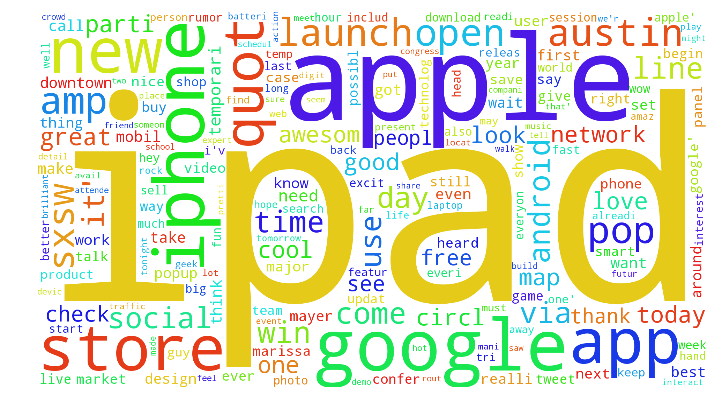

In [756]:
# Define the wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=1920, height=1080).generate(' '.join(updated_entire_data))
plt.figure(figsize=[12,8])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Build the vocabulary of unique words

In [310]:
count_entire_data = Counter(updated_entire_data)

In [312]:
# Create vocab i.e. unique words in the entire data
vocab = dict(count_entire_data).keys()

## Initializing Count Vectorizer and getting the matrix X and predicted labels y

In [660]:
cv = CountVectorizer(vocabulary=vocab, ngram_range=(1,3))

In [661]:
X=cv.fit_transform(new_sentences).toarray()

In [662]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [663]:
y = new_data.sentiment.values

## Making the train/test split

In [664]:
# Making the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Initializing the models

In [665]:
# Defining the models
nb = MultinomialNB()
clf = svm.SVC(kernel='linear')
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()
abc = AdaBoostClassifier()

## Fitting the data to different models

In [666]:
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [667]:
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [668]:
rfc.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [669]:
etc.fit(X_train, y_train) 

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [670]:
abc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

## Predicting based on X_test

In [671]:
nb_pred_vals = nb.predict(X_test)

In [672]:
svc_pred_vals = clf.predict(X_test)

In [673]:
rfc_pred_vals = rfc.predict(X_test)

In [674]:
etc_pred_vals = etc.predict(X_test)

In [675]:
abc_pred_vals = abc.predict(X_test)

## Calculating Accuracy

In [676]:
accuracy_nb = accuracy_score(y_test,nb_pred_vals)
accuracy_svm = accuracy_score(y_test,svc_pred_vals)
accuracy_rfc = accuracy_score(y_test,rfc_pred_vals)
accuracy_etc = accuracy_score(y_test,etc_pred_vals)
accuracy_abc = accuracy_score(y_test,abc_pred_vals)

## Calculating F1-Score

In [677]:
f1_nb = f1_score(y_test,nb_pred_vals,average='weighted')
f1_svm = f1_score(y_test,svc_pred_vals,average='weighted')
f1_rfc = f1_score(y_test,rfc_pred_vals,average='weighted')
f1_etc = f1_score(y_test,etc_pred_vals,average='weighted')
f1_abc = f1_score(y_test,abc_pred_vals,average='weighted')

## Comparing accuracy / F1 scores of different models

In [678]:
models = ["Multinomial NaiveBayes","SVM","RandomForest Classifier","ExtraTrees Classifier","AdaBoost Classifier"]

In [679]:
f1_scores = [f1_nb,f1_svm,f1_rfc,f1_etc,f1_abc]

In [680]:
accuracy = [accuracy_nb,accuracy_svm,accuracy_rfc,accuracy_etc,accuracy_abc]

In [681]:
sorted_models_accuracy = [model for acc, model in sorted(zip(accuracy, models), reverse=True)]
sorted_models_f1 = [model for f1, model in sorted(zip(f1_scores, models), reverse=True)]

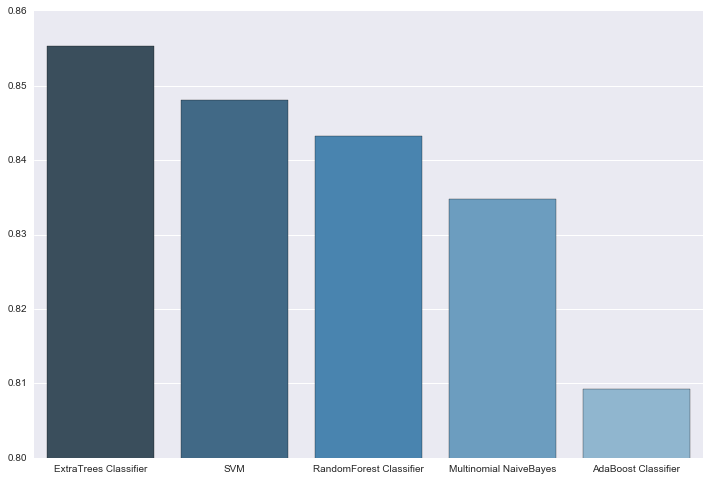

In [682]:
plt.figure(figsize=[12,8])
sns.barplot(x=sorted_models_accuracy, y=sorted(accuracy, reverse=True), palette="Blues_d")
plt.ylim((0.8,0.86));

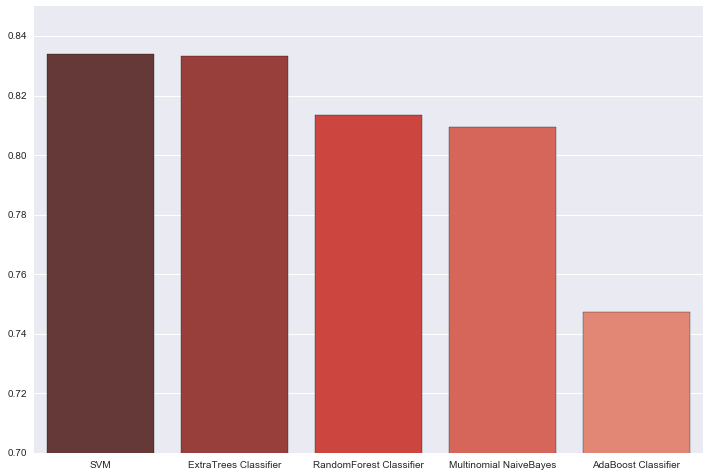

In [683]:
plt.figure(figsize=[12,8])
sns.barplot(x=sorted_models_f1, y=sorted(f1_scores, reverse=True), palette="Reds_d")
plt.ylim((0.70,0.85));

## Converting string labels to integer labels to prepare data for GridSearch

In [684]:
y_numerical = new_data['sentiment'].map({'Positive':2,'Negative':1,'Neutral':0}).values

In [685]:
# Making the train test split based on numerical labels
X_train_numerical, X_test_numerical, y_train_numerical, y_test_numerical = train_test_split(X, y_numerical, test_size=0.25, random_state=42)

## Implementing Grid Search for ExtraTreesClassifier

In [687]:
# Defining the parameter grid
extra_trees_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [1, 4],
                      'min_samples_leaf': [1, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 30],
                      'random_state': [1]}

# Running gridsearch on the parameter grid
etc_gridsearch = GridSearchCV(ExtraTreesClassifier(),
                             extra_trees_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='mean_squared_error')

# Fitting the train data prepared above
etc_gridsearch.fit(X_train_numerical, y_train_numerical)

# Printing the best parameters
print "best parameters:", etc_gridsearch.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 30.5min finished


best parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 30, 'min_samples_split': 4, 'random_state': 1, 'max_features': 'sqrt', 'max_depth': None}


In [1044]:
# Printing the best model and the score
best_etc_model = etc_gridsearch.best_estimator_

In [1045]:
# Just looking at the best model
best_etc_model

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [718]:
# Defining a function to calculate f1 scores and accuracy
def cross_validation_scores(X_train, X_test, y_train, y_test):
    '''
    INPUT: Train data and test data for X and y
    OUTPUT: Array(f1_scores), Array(accuracy_score)
    '''
    # Getting the best model
    etc_model = best_etc_model
    # Fitting the data
    etc_model.fit(X_train,y_train)
    # Calculating f1 weighted scores
    f1_scores = cross_validation.cross_val_score(etc_model,X_test,y_test,cv=15, scoring="f1_weighted")
    # Calculating accuracy
    acc_scores = cross_validation.cross_val_score(etc_model,X_test,y_test,cv=15, scoring="accuracy")
    # Return f1 score and accuracy
    return f1_scores, acc_scores

In [705]:
# Save the cross validation scores returned from the function in a variable
cross_val_scores = cross_validation_scores(X_train, X_test, y_train, y_test)

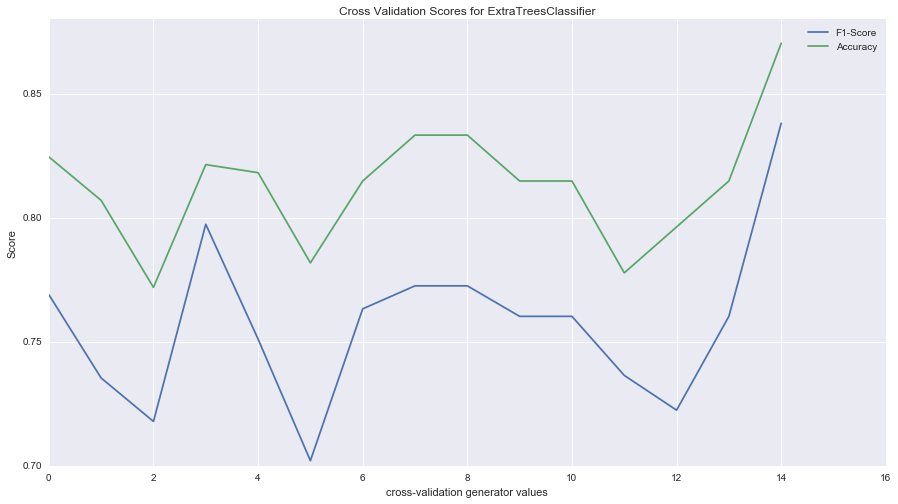

In [717]:
# Plot the cross_val_scores
plt.figure(figsize=(15,8))
plt.plot(cross_val_scores[0])
plt.plot(cross_val_scores[1])
plt.xlim((0,16));
plt.xlabel('cross-validation generator values')
plt.ylabel('Score')
plt.title('Cross Validation Scores for ExtraTreesClassifier')
plt.legend(["F1-Score","Accuracy"], loc='upper right')
plt.show()

## Building a confusion matrix for the best model

In [699]:
confusion_matrix(y_test,etc_pred_vals)

array([[ 61,   0,  78],
       [  3,   1,  17],
       [ 20,   1, 642]])

In [700]:
cm = ConfusionMatrix(y_test, etc_pred_vals)

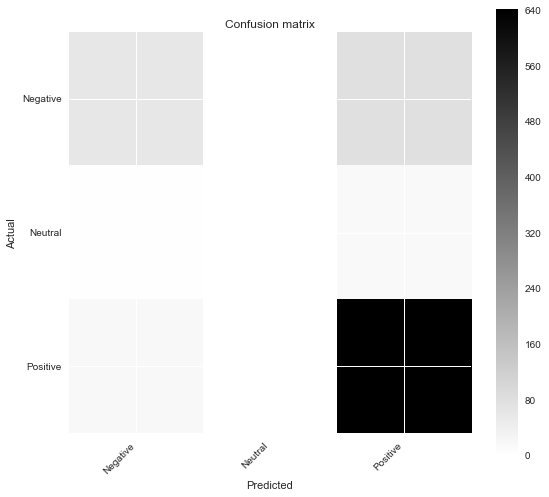

In [701]:
cm.plot();

## Using the TfidfVectorizer to see if it improves accuracy of the model

In [491]:
tfidf = TfidfVectorizer(vocabulary=vocab)

In [492]:
X_tfidf = tfidf.fit_transform(new_sentences).toarray()

In [493]:
X_tfidf

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [502]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [1041]:
best_etc_model.fit(X_train_tfidf, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [1042]:
etc_tfidf_pred = etc.predict(X_test_tfidf)

In [1047]:
print "Accuracy: ",accuracy_score(y_test,etc_tfidf_pred)
print "F1-Score: ",f1_score(y_test,etc_tfidf_pred,average='weighted')

Accuracy:  0.855407047388
F1-Score:  0.833458863052


## Word2Vec 

In [758]:
from gensim import corpora, models, similarities
from gensim.models.word2vec import Word2Vec

In [791]:
filtered_sentence = []
for tweet in filtered_tweets_url:
    filtered_sentence.append(' '.join(tweet))

In [792]:
filtered_sentence[1]

u"ipad appreci give app they'r free like also you'll design iphone awesom know"

In [840]:
filtered_tweets_url[1]

[u'ipad',
 u'appreci',
 u'give',
 u'app',
 u"they'r",
 u'free',
 u'like',
 u'also',
 u"you'll",
 u'design',
 'iphone',
 u'awesom',
 u'know']

In [897]:
# Removing all urls from the tweets
w2v_sentence = []
for tweet,sentence in zip(tweet_text_filtered,new_sentences):
    w2v_sentence.append(list(set(tweet)
                                    -set(re.findall(url, sentence, flags=0))
                                    -set(re.findall(handles, sentence, flags=0))
                                    -set(re.findall(hashtags, sentence, flags=0))))

In [899]:
# Removing all words less than length of 2
w2v_sentence_rem_sm_wd = []
w2v_sentence_temp = []
for tweet in w2v_sentence:
    w2v_sentence_temp = []
    for word in tweet:
        if len(word) > 2:
            w2v_sentence_temp.append(word)
    w2v_sentence_rem_sm_wd.append(w2v_sentence_temp)

In [901]:
w2v_sentence_rem_sm_wd[1]

['ipad',
 "they're",
 'giving',
 'awesome',
 'appreciate',
 'likely',
 'free',
 'also',
 "you'll",
 'design',
 'iphone',
 'app',
 'know']

In [1066]:
# model = Word2Vec(LineSentence(infile), size=200, min_count=5, workers=4)
model = Word2Vec(w2v_sentence_rem_sm_wd, size=200, min_count=5, window = 5)

In [1068]:
model_name = "w2v_first_model"
model.save(model_name)

In [1069]:
model.most_similar('maps')

[('users', 0.991290807723999),
 ('party', 0.9911647439002991),
 ('search', 0.9902166724205017),
 ('marissa', 0.9887163639068604),
 ('fun', 0.9815832376480103),
 ('worlds', 0.9788117408752441),
 ('hotpot', 0.976046085357666),
 ('saving', 0.9758152961730957),
 ('big', 0.9745327234268188),
 ('awesome', 0.9737551212310791)]

In [1116]:
def vectorizer(tweet):
    '''
    Input: Takes in a string (tweet)
    Output: Returns the averaged vector for a tweet as numpy array
    '''
    tweet = tweet.split()
    w2v_vector_sum = 0
    for word in tweet:
        if word in model.vocab:
            w2v_vector_sum += model[word]
    return np.asarray(w2v_vector_sum/len(tweet))

In [1121]:
# Create vectorized list
vectorized_list = []
for tweet in filtered_sentence_rem_sm_wd:
    vectorized_list.append(vectorizer(tweet))

In [1124]:
vectorized_list[1]

array([-0.0032013 ,  0.00379287, -0.01468364,  0.00120866,  0.01958985,
       -0.00021769,  0.0002011 , -0.01341416, -0.01473748, -0.00632167,
        0.00100591,  0.00285862, -0.01315262, -0.01025625,  0.02179063,
       -0.01726107,  0.03008166, -0.02441887,  0.01912558, -0.00817374,
       -0.02260858, -0.00292914, -0.02799538, -0.00101974,  0.01278347,
       -0.00136051,  0.00016651, -0.01521407, -0.00107516,  0.00232555,
       -0.00432409, -0.00826718,  0.00358371,  0.01527398,  0.00450414,
        0.0167495 ,  0.0008395 , -0.02808351, -0.01645363, -0.00310839,
       -0.00927399,  0.0064035 ,  0.00951814, -0.0247311 , -0.0169742 ,
       -0.00361123, -0.00692802,  0.00123875,  0.00024589,  0.01140301,
        0.00584099,  0.00775178,  0.00606085, -0.0040379 ,  0.00095733,
        0.012637  ,  0.0053049 ,  0.01469654,  0.01009501, -0.02686182,
       -0.0021066 , -0.00709751, -0.01084655,  0.02653901, -0.01593016,
       -0.00165773, -0.00550058, -0.0018004 , -0.01746556, -0.00

## Graph Lab

In [776]:
import graphlab as gl

In [789]:
# Creating a new SFrame based on new_data
data_sf = gl.SFrame(new_data)

In [915]:
# Join list items to create a sentence
filtered_sentence_rem_sm_wd = []
for tweet in w2v_sentence_rem_sm_wd:
    filtered_sentence_rem_sm_wd.append(' '.join(tweet))

In [916]:
data_sf['filtered_tweets'] = filtered_sentence_rem_sm_wd

In [ ]:
# Create Unigrams

In [917]:
wc_filtered_tweets = gl.text_analytics.count_words(data_sf['filtered_tweets'])
data_sf['wc_filtered_tweets'] = wc_filtered_tweets

In [918]:
# Create Bigrams

In [ ]:
bigram_filtered_tweets = gl.text_analytics.count_ngrams(data_sf['filtered_tweets'], n=2)
data_sf['bigram_filtered_tweets'] = bigram_filtered_tweets

In [919]:
data_sf['tfidf'] = gl.text_analytics.tf_idf(data_sf['wc_filtered_tweets'])

In [ ]:
# Tweet length

In [1005]:
tweet_length = []
tweet_length_sum = 0
for tweet in w2v_sentence_rem_sm_wd:
    tweet_length_sum = 0
    for word in tweet:
        tweet_length_sum +=1
    tweet_length.append(tweet_length_sum)

In [1008]:
tweet_length[1:10]

[13, 3, 7, 15, 9, 7, 10, 9, 11]

In [1009]:
data_sf['tweet_length'] = tweet_length

In [1106]:
data_sf[1:3]

Columns:
	tweet_text	str
	brand_product	str
	sentiment	str
	filtered_tweets	str
	wc_filtered_tweets	dict
	tfidf	dict
	bigram_filtered_tweets	dict
	tweet_length	int

Rows: 2

Data:
+-------------------------------+--------------------+-----------+
|           tweet_text          |   brand_product    | sentiment |
+-------------------------------+--------------------+-----------+
| @jessedee Know about @flud... | iPad or iPhone App |  Positive |
| @swonderlin Can not wait f... |        iPad        |  Positive |
+-------------------------------+--------------------+-----------+
+-------------------------------+-------------------------------+
|        filtered_tweets        |       wc_filtered_tweets      |
+-------------------------------+-------------------------------+
| ipad they're giving awesom... | {'ipad': 1, "they're": 1, ... |
|         also sale wait        | {'also': 1, 'sale': 1, 'wa... |
+-------------------------------+-------------------------------+
+-------------------------------+-------------------------------+--------------+
|             tfidf             |     bigram_filtered_tweets    | tweet_length |
+-------------------------------+-------------------------------+--------------+
| {'ipad': 1.108690248449459... | {'ll design': 1, 'giving a... |      13      |
| {'also': 4.410067294829403... | {'also sale': 1, 'sale wai... |      3       |
+-------------------------------+-------------------------------+--------------+
[2 rows x 8 columns]

BM25 is a bag-of-words retrieval function that ranks a set of documents based on the query terms appearing in each document, regardless of the inter-relationship between the query terms within a document (e.g., their relative proximity).

In [1011]:
sample_words = ['iphone', 'google', 'android','store','market','ipad','apple']
bm25_scores = gl.text_analytics.bm25(wc_filtered_tweets, sample_words)

In [1012]:
bm25_scores[1:6]

doc_id,bm25
1,1.87535258791
3,1.7250242825
4,1.10040220789
6,0.781672331387
7,1.17732196647


In [1013]:
# Learn topic model
topic_model = gl.topic_model.create(data_sf['wc_filtered_tweets'])

PROGRESS: Learning a topic model
PROGRESS:        Number of documents      3291
PROGRESS:            Vocabulary size      5023
PROGRESS:    Running collapsed Gibbs sampling
PROGRESS: +-----------+---------------+----------------+-----------------+
PROGRESS: | Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |
PROGRESS: +-----------+---------------+----------------+-----------------+
PROGRESS: | 10        | 143.857ms     | 3.11602e+06    | 0               |
PROGRESS: +-----------+---------------+----------------+-----------------+


In [1014]:
print topic_model.get_topics(num_words=4)

+-------+--------+-----------------+
| topic |  word  |      score      |
+-------+--------+-----------------+
|   0   |  quot  |  0.033889966139 |
|   0   |  app   | 0.0324429137846 |
|   0   |  new   | 0.0309958614303 |
|   0   |  day   | 0.0266547043672 |
|   1   |  ipad  |  0.156265370483 |
|   1   | launch | 0.0367734282325 |
|   1   |  like  | 0.0356161212858 |
|   1   |  need  | 0.0173885368747 |
|   2   | iphone |  0.153589463426 |
|   2   |  ipad  | 0.0460975105572 |
+-------+--------+-----------------+
[40 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [1015]:
for topic_id in range(10):
    print "Topic " + str(topic_id+1) + ": " +str(topic_model.get_topics(num_words=10, output_type='topic_words')['words'][topic_id])

Topic 1: ['quot', 'app', 'new', 'day', 'free', 'check', 'google', 'amp', 'marissa', 'wins']
Topic 2: ['ipad', 'launch', 'like', 'need', 'popup', 'want', 'temporary', 'austin', 'sxsw', 'circles']
Topic 3: ['iphone', 'ipad', "it's", 'awesome', "i'm", 'users', 'big', 'downtown', 'phone', 'video']
Topic 4: ['new', 'party', 'good', 'via', "it's", 'opening', 'austin', 'design', 'great', 'right']
Topic 5: ['ipad', 'apple', 'app', 'amp', 'circles', 'store', 'begins', 'know', 'come', 'live']
Topic 6: ['android', 'get', 'store', 'quot', 'people', 'temporary', 'game', 'coming', 'temp', 'excited']
Topic 7: ['app', 'see', 'cool', 'sxsw', 'even', 'quot', 'still', 'great', 'comes', 'conferences']
Topic 8: ['apple', 'store', 'austin', 'line', 'pop-up', 'love', 'pop', 'got', 'year', 'ipads']
Topic 9: ['google', 'time', 'mobile', 'mayer', 'heard', 'great', 'technology', 'make', 'maps', 'first']
Topic 10: ['social', 'one', 'thanks', 'network', 'called', 'would', 'yes', 'today', 'cool', 'much']


## Logistic Regression for classification

In [1025]:
# Splitting data to train and test
train_data, test_data = data_sf.random_split(0.75)

# Create a logistic regression classifer model.
lr_model = gl.logistic_classifier.create(train_data, target='sentiment', features = ['wc_filtered_tweets'])

# Get the predictions
lr_model_predictions = lr_model.classify(test_data)

# Evaluate the model and save the results into a dictionary
lr_model_results = lr_model.evaluate(test_data)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 2361
PROGRESS: Number of classes           : 3
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 4263
PROGRESS: Number of coefficients    : 8528
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000424  | 0.016824     | 0.823380          | 0.868217            |
PROGR

In [1027]:
lr_model_predictions['sentiment'] = test_data['sentiment']

In [1030]:
lr_model_predictions[30:50]

class,probability,sentiment
Positive,0.994030599211,Positive
Positive,0.99225622992,Positive
Positive,0.998550484439,Negative
Positive,0.971000678604,Negative
Positive,0.984048602866,Positive
Positive,0.958500179171,Positive
Positive,0.999989337443,Positive
Negative,0.671803293198,Negative
Positive,0.931467565682,Positive
Positive,0.999085373932,Positive


In [1031]:
f1_lm_model_uni = gl.evaluation.f1_score(test_data['sentiment'], lr_model_predictions['class'],average='macro')
lm_precision_uni   = gl.evaluation.precision(test_data['sentiment'], lr_model_predictions['class'], average='macro')
lm_recall_uni  = gl.evaluation.recall(test_data['sentiment'], lr_model_predictions['class'], average='macro')

In [1032]:
f1_lm_model_uni, lm_precision_uni, lm_recall_uni

(0.46854005886806616, 0.4983150183150183, 0.4534313725490196)

In [1033]:
## Model with bigrams

In [1038]:
# Create a logistic regression classifer model.
lr_model2 = gl.logistic_classifier.create(train_data, target='sentiment', features = ['bigram_filtered_tweets'])

# Get the predictions
lr_model2_predictions= lr_model2.classify(test_data)

# Evaluate the model and save the results into a dictionary
lr_model2_results = lr_model2.evaluate(test_data)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 2358
PROGRESS: Number of classes           : 3
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 13651
PROGRESS: Number of coefficients    : 27304
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000424  | 0.023259     | 0.977947          | 0.840909            |
PRO

In [1039]:
f1_lm_model_bigram = gl.evaluation.f1_score(test_data['sentiment'], lr_model2_predictions['class'],average='macro')
lm_precision_bigram   = gl.evaluation.precision(test_data['sentiment'], lr_model2_predictions['class'], average='macro')
lm_recall_bigram  = gl.evaluation.recall(test_data['sentiment'], lr_model2_predictions['class'], average='macro')

In [1040]:
f1_lm_model_bigram, lm_precision_bigram, lm_recall_bigram

(0.4436634625561682, 0.5022956841138659, 0.42582559339525283)